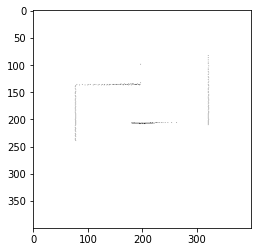

In [ ]:
import PIL
from PIL import Image
import pathlib
import math
import matplotlib.pyplot as plt

# Define the maximum distance the Lidar can measure
max_distance = 360

# Define the number of rays the Lidar will emit for each scan
no_of_rays = 360

# Load the world map image
image = Image.open(pathlib.Path('/content/drive/MyDrive/worldmap.jpg'))
image = image.convert('1')
image.thumbnail((400, 400))
image_size = min(image.size)

# Create an empty map of the same size as the world map
map_image = Image.new('1', (image_size, image_size), color=1)

# Set the initial scan position to the center of the map
centerX = image_size // 2
centerY = image_size // 2

# Define a function to update the map based on the Lidar readings
def update_map(lidar_reading, current_x, current_y):
    # Iterate through the Lidar readings
    for angle, distance in lidar_reading:
        # Convert the angle to radians
        angle_radians = math.radians(angle)
        # Calculate the x and y coordinates of the obstacle
        obstacle_x = current_x + int(distance * math.cos(angle_radians))
        obstacle_y = current_y + int(distance * math.sin(angle_radians))
        # Update the map with the obstacle position
        if obstacle_x >= 0 and obstacle_x < image_size and obstacle_y >= 0 and obstacle_y < image_size:
            map_image.putpixel((obstacle_x, obstacle_y), 0)

# Iterate until the entire map is mapped
while map_image.getextrema()[0] == 1:
    # Take a Lidar scan at the current position
    lidar_reading = []
    if image.getpixel((centerX, centerY)) == 0:
        print('Invalid starting position')
        break
    for i in range(0, 360, int(360 / no_of_rays)):
        r = 0
        currentX = round(centerX + r * math.cos(i * math.pi / 180))
        currentY = round(centerY + r * math.sin(i * math.pi / 180))
        while ((currentX < image_size and currentX >= 0) and (currentY < image_size and currentY >=0) and (image.getpixel((currentX, currentY)) != 0)):
            currentX = round(centerX + r * math.cos(i * math.pi / 180))
            currentY = round(centerY + r * math.sin(i * math.pi / 180))
            r += 1
        if r > max_distance:
            r = max_distance
        lidar_reading.append((i, r))

    # Update the map with the Lidar readings
    update_map(lidar_reading, centerX, centerY)

    # Determine the next scan position by finding the closest unexplored area
    min_distance = image_size * 2
    for x in range(image_size):
        for y in range(image_size):
            if map_image.getpixel((x, y)) == 1:
                distance = math.sqrt((x - centerX) ** 2 + (y - centerY) ** 2)
                if distance < min_distance:
                    next_x, next_y = x, y
                    min_distance = distance

    # Move to the next scan position
    centerX, centerY = next_x, next_y

# Display the final map
plt.imshow(map_image)